# Anomaly Detection: LSTM + AE with GARCH for dynamic threshold (NAB Dataset)

In [ ]:
!pip install arch -q
!git clone https://github.com/numenta/NAB.git

Epoch [10/50], Loss: 0.002759
Epoch [20/50], Loss: 0.002431
Epoch [30/50], Loss: 0.001962
Epoch [40/50], Loss: 0.000837
Epoch [50/50], Loss: 0.000309


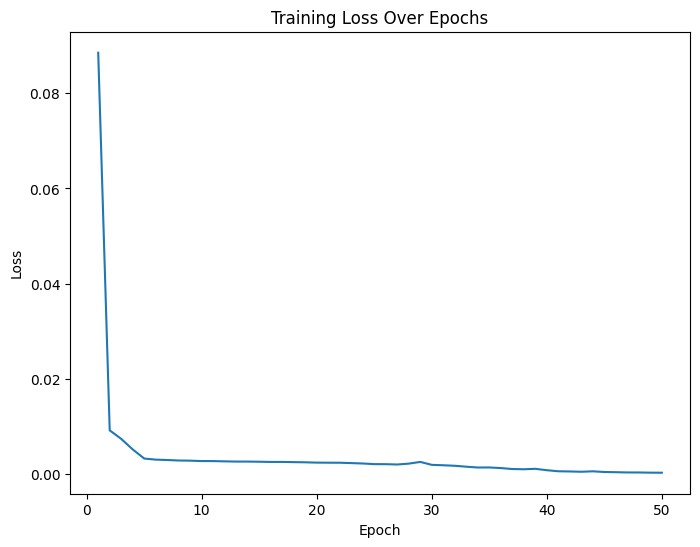

In [118]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import os
from arch import arch_model
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset

# Bidirectional LSTM AutoEncoder model class
class BiLSTMAutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(BiLSTMAutoEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.decoder = nn.LSTM(hidden_size * 2, hidden_size * 2, num_layers, batch_first=True, bidirectional=True)
        self.output_layer = nn.Linear(hidden_size * 4, input_size)  # 추가된 선형 계층

    def forward(self, x):
        # 인코더
        _, (hidden, _) = self.encoder(x)
        # hidden의 형태: (num_layers * num_directions, batch, hidden_size)
        # 두 방향의 은닉 상태를 결합
        hidden = hidden.view(self.num_layers, 2, x.size(0), self.hidden_size)
        hidden = torch.cat((hidden[:,0,:,:], hidden[:,1,:,:]), dim=2)
        # 디코더 입력 준비
        decoder_input = hidden.repeat(x.size(1), 1, 1).permute(1, 0, 2)
        # 디코더
        decoded, _ = self.decoder(decoder_input)
        # 출력 차원 조정
        decoded = decoded.reshape(decoded.size(0), decoded.size(1), -1)
        output = self.output_layer(decoded)
        return output

# -------------------------------
# 1. 학습 데이터 로드 및 전처리
# -------------------------------

# 학습 데이터셋 경로 설정
train_data_dir = 'NAB/data/artificialNoAnomaly'

# 학습 데이터 파일 선택 (예: art_daily_no_noise.csv)
train_data_file = os.path.join(train_data_dir, 'art_daily_no_noise.csv')

# 학습 데이터 로드
df_train = pd.read_csv(train_data_file)

# 타임스탬프를 datetime 형식으로 변환
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])

# 타임스탬프를 인덱스로 설정
df_train.set_index('timestamp', inplace=True)

# x_train 생성 및 정규화
x_train = df_train['value'].values.reshape(-1, 1)

# 데이터 정규화
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)

# 시퀀스 생성
sequence_length = 10
train_sequences = []
for i in range(len(x_train) - sequence_length):
    train_sequences.append(x_train[i:i + sequence_length])

# 텐서로 변환
train_sequences = torch.tensor(train_sequences, dtype=torch.float32)

# TensorDataset과 DataLoader 생성
batch_size = 64
train_dataset = TensorDataset(train_sequences)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# -------------------------------
# 2. 모델 정의 및 학습
# -------------------------------

# 모델 정의
input_size = 1
hidden_size = 32  # hidden_size를 늘림
num_layers = 1
model = BiLSTMAutoEncoder(input_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델을 GPU로 이동 (가능한 경우)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 학습 루프
num_epochs = 50
loss_list = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        batch_sequences = batch[0].to(device)
        outputs = model(batch_sequences)
        loss = criterion(outputs, batch_sequences)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_loader)
    loss_list.append(avg_loss)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.6f}')

# 학습 손실 시각화
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

Scaled Reconstruction Errors Mean: 0.2314874827861786
GARCH(1, 1) - Precision: 0.9744, Recall: 0.2829, F1-score: 0.4385
GARCH(1, 2) - Precision: 0.9333, Recall: 0.2779, F1-score: 0.4283
GARCH(1, 3) - Precision: 0.0633, Recall: 0.2308, F1-score: 0.0993
GARCH(1, 4) - Precision: 0.7914, Recall: 0.3201, F1-score: 0.4558
GARCH(2, 1) - Precision: 0.9597, Recall: 0.2953, F1-score: 0.4516
GARCH(2, 2) - Precision: 0.0633, Recall: 0.2308, F1-score: 0.0993
GARCH(2, 3) - Precision: 0.9296, Recall: 0.1638, F1-score: 0.2785
GARCH(2, 4) - Precision: 0.9316, Recall: 0.2705, F1-score: 0.4192
GARCH(3, 1) - Precision: 0.0633, Recall: 0.2308, F1-score: 0.0993
GARCH(3, 2) - Precision: 0.8244, Recall: 0.2680, F1-score: 0.4045
GARCH(3, 3) - Precision: 0.9597, Recall: 0.2953, F1-score: 0.4516
GARCH(3, 4) - Precision: 0.0633, Recall: 0.2308, F1-score: 0.0993
GARCH(4, 1) - Precision: 0.9590, Recall: 0.2903, F1-score: 0.4457
GARCH(4, 2) - Precision: 0.9597, Recall: 0.2953, F1-score: 0.4516
GARCH(4, 3) - Precisio

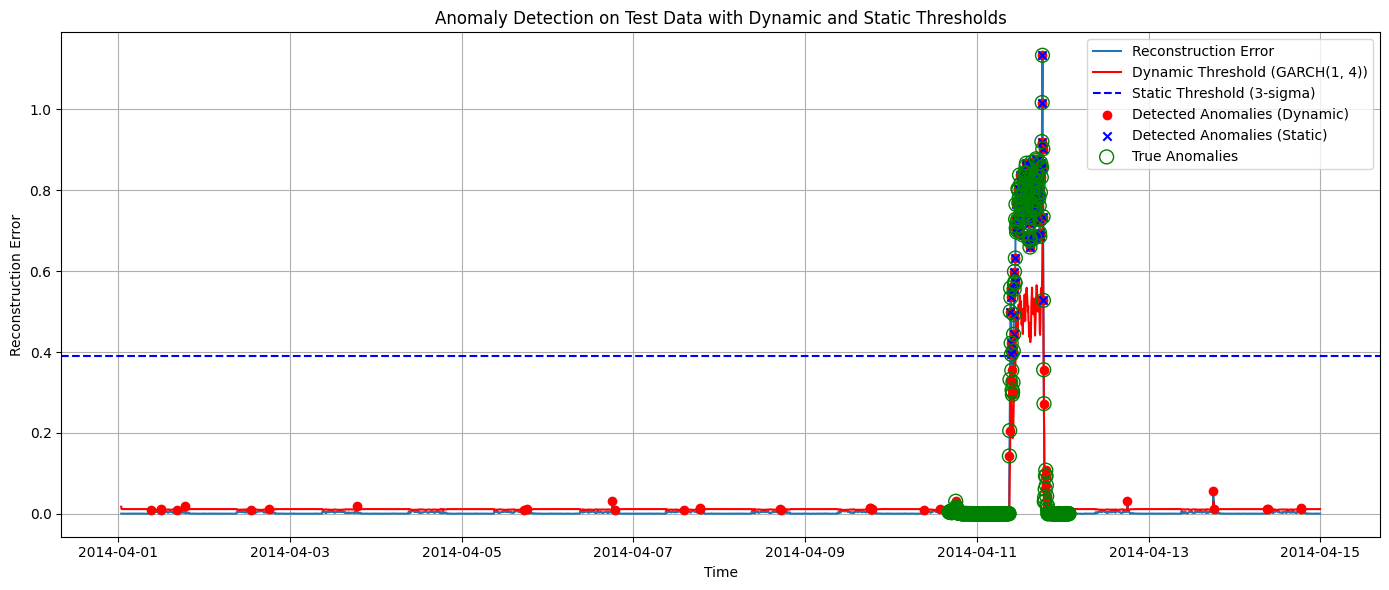

In [119]:
# -------------------------------
# 3. 테스트 데이터 로드 및 전처리
# -------------------------------

# 테스트 데이터셋 경로 설정
test_data_dir = 'NAB/data/artificialWithAnomaly'

# 테스트 데이터 파일 선택 (예: art_daily_jumpsup.csv)
test_data_file = os.path.join(test_data_dir, 'art_daily_jumpsup.csv')

# 테스트 데이터 로드
df_test = pd.read_csv(test_data_file)

# 타임스탬프를 datetime 형식으로 변환
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])

# 타임스탬프를 인덱스로 설정
df_test.set_index('timestamp', inplace=True)

# x_test 생성 및 정규화 (학습 시 사용한 스케일러 사용)
x_test = df_test['value'].values.reshape(-1, 1)
x_test = scaler.transform(x_test)

# 시퀀스 생성
test_sequences = []
for i in range(len(x_test) - sequence_length):
    test_sequences.append(x_test[i:i + sequence_length])

# 텐서로 변환
test_sequences = torch.tensor(test_sequences, dtype=torch.float32)

# TensorDataset과 DataLoader 생성
test_dataset = TensorDataset(test_sequences)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# -------------------------------
# 4. 모델 테스트 및 이상치 탐지
# -------------------------------

# Reconstruct sequences and calculate reconstruction error
model.eval()
with torch.no_grad():
    reconstructed = []
    for batch in test_loader:
        batch_sequences = batch[0].to(device)
        outputs = model(batch_sequences)
        reconstructed.extend(outputs.cpu().numpy())
reconstructed = np.array(reconstructed)
test_sequences_np = test_sequences.numpy()
reconstruction_errors = np.mean((test_sequences_np - reconstructed) ** 2, axis=(1, 2))

# -------------------------------
# 5. 이상치 레이블 로드
# -------------------------------

# 이상치 레이블 로드
labels_file = 'NAB/labels/combined_windows.json'

with open(labels_file, 'r') as f:
    labels = json.load(f)

# 현재 테스트 데이터 파일의 상대 경로
test_data_file_relative = os.path.relpath(test_data_file, start='NAB/data')

# 해당 데이터 파일의 이상치 구간 가져오기
anomaly_windows = labels.get(test_data_file_relative, [])

# 이상치 레이블 생성
true_anomalies = np.zeros(len(reconstruction_errors), dtype=bool)
time_index = df_test.index[sequence_length:].to_pydatetime()

for window in anomaly_windows:
    start = pd.to_datetime(window[0])
    end = pd.to_datetime(window[1])
    mask = (time_index >= start) & (time_index <= end)
    true_anomalies |= mask

# -------------------------------
# 6. GARCH 모델을 사용한 동적 임계값 적용
# -------------------------------

from arch import arch_model

# 재구성 오류 스케일링 (GARCH 모델의 수렴을 돕기 위해)
scaling_factor = 10
reconstruction_errors_scaled = reconstruction_errors * scaling_factor

# 데이터 스케일 확인
print(f"Scaled Reconstruction Errors Mean: {np.mean(reconstruction_errors_scaled)}")

# GARCH 모델에서 테스트할 p와 q의 조합 설정
p_values = [1, 2, 3, 4]
q_values = [1, 2, 3, 4]

# 결과 저장을 위한 리스트 초기화
results = []

# 모든 p, q 조합에 대해 반복
for p in p_values:
    for q in q_values:
        try:
            # GARCH 모델 적합
            model_garch = arch_model(reconstruction_errors_scaled, vol='Garch', p=p, q=q)
            results_garch = model_garch.fit(disp='off', show_warning=False)

            # 동적 임계값 계산
            conditional_volatility = results_garch.conditional_volatility
            threshold = conditional_volatility * 1 # Dynamic threshold (3-sigma rule)
            threshold = threshold / scaling_factor  # 임계값을 원래 스케일로 변환

            # 이상치 탐지
            anomalies = reconstruction_errors > threshold

            # 성능 평가
            precision = precision_score(true_anomalies, anomalies, zero_division=0)
            recall = recall_score(true_anomalies, anomalies, zero_division=0)
            f1 = f1_score(true_anomalies, anomalies, zero_division=0)

            # 결과 저장
            results.append({
                'p': p,
                'q': q,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'threshold': threshold,
                'anomalies': anomalies
            })

            print(f'GARCH({p}, {q}) - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

        except Exception as e:
            print(f'GARCH({p}, {q}) - Error fitting model: {e}')

# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results)

# Recall이 가장 높은 조합 찾기
best_recall = results_df.loc[results_df['recall'].idxmax()]
print(f"\nBest Recall:\nGARCH({int(best_recall['p'])}, {int(best_recall['q'])}) with Recall = {best_recall['recall']:.4f}")

# 최적의 p, q 값 설정
p_optimal = int(best_recall['p'])
q_optimal = int(best_recall['q'])
threshold_optimal = best_recall['threshold']
anomalies_optimal = best_recall['anomalies']

# -------------------------------
# 7. 최적의 GARCH 모델로 이상치 탐지 및 성능 평가
# -------------------------------

# 성능 평가
precision = precision_score(true_anomalies, anomalies_optimal, zero_division=0)
recall = recall_score(true_anomalies, anomalies_optimal, zero_division=0)
f1 = f1_score(true_anomalies, anomalies_optimal, zero_division=0)

print(f'\nFinal Performance with GARCH({p_optimal}, {q_optimal}):')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

# 혼동 행렬 출력
cm = confusion_matrix(true_anomalies, anomalies_optimal)
tn, fp, fn, tp = cm.ravel()

print('Confusion Matrix:')
print(cm)
print(f'True Negatives (TN): {tn}')
print(f'False Positives (FP): {fp}')
print(f'False Negatives (FN): {fn}')
print(f'True Positives (TP): {tp}')

# -------------------------------
# 8. 결과 시각화 (동적 임계값 + 정적 임계값)
# -------------------------------

# 정적 임계값 계산 (3-sigma 규칙)
static_threshold = np.mean(reconstruction_errors) + 3 * np.std(reconstruction_errors)

# 이상치 탐지 (정적 임계값 기준)
anomalies_static = reconstruction_errors > static_threshold

# 성능 평가 for dynamic threshold
precision_dynamic = precision_score(true_anomalies, anomalies_optimal, zero_division=0)
recall_dynamic = recall_score(true_anomalies, anomalies_optimal, zero_division=0)
f1_dynamic = f1_score(true_anomalies, anomalies_optimal, zero_division=0)

print(f'\nPerformance with Dynamic Threshold (GARCH({p_optimal}, {q_optimal})):')
print(f'Precision: {precision_dynamic:.4f}')
print(f'Recall: {recall_dynamic:.4f}')
print(f'F1-score: {f1_dynamic:.4f}')

# 성능 평가 for static threshold
precision_static = precision_score(true_anomalies, anomalies_static, zero_division=0)
recall_static = recall_score(true_anomalies, anomalies_static, zero_division=0)
f1_static = f1_score(true_anomalies, anomalies_static, zero_division=0)

print(f'\nPerformance with Static Threshold (3-sigma):')
print(f'Precision: {precision_static:.4f}')
print(f'Recall: {recall_static:.4f}')
print(f'F1-score: {f1_static:.4f}')
print()

# 혼동 행렬 for dynamic threshold
cm_dynamic = confusion_matrix(true_anomalies, anomalies_optimal)
if cm_dynamic.size == 4:
    tn, fp, fn, tp = cm_dynamic.ravel()
    print('Confusion Matrix (Dynamic):')
    print(cm_dynamic)
    print(f'True Negatives (TN): {tn}')
    print(f'False Positives (FP): {fp}')
    print(f'False Negatives (FN): {fn}')
    print(f'True Positives (TP): {tp}')
else:
    print('Confusion Matrix (Dynamic):')
    print(cm_dynamic)

# 혼동 행렬 for static threshold
cm_static = confusion_matrix(true_anomalies, anomalies_static)
if cm_static.size == 4:
    tn, fp, fn, tp = cm_static.ravel()
    print('Confusion Matrix (Static):')
    print(cm_static)
    print(f'True Negatives (TN): {tn}')
    print(f'False Positives (FP): {fp}')
    print(f'False Negatives (FN): {fn}')
    print(f'True Positives (TP): {tp}')
else:
    print('Confusion Matrix (Static):')
    print(cm_static)

# 결과 시각화
plt.figure(figsize=(14, 6))

# 재구성 오류 플롯
plt.plot(df_test.index[sequence_length:], reconstruction_errors, label='Reconstruction Error')

# 동적 임계값 플롯 (GARCH 기반)
plt.plot(df_test.index[sequence_length:], threshold_optimal,
         label=f'Dynamic Threshold (GARCH({p_optimal}, {q_optimal}))', color='red')

# 정적 임계값 플롯 (3-sigma 규칙)
plt.axhline(y=static_threshold, color='blue', linestyle='--',
            label='Static Threshold (3-sigma)')

# 탐지된 이상치 표시 (동적 임계값 기준)
plt.scatter(df_test.index[sequence_length:][anomalies_optimal],
            reconstruction_errors[anomalies_optimal],
            color='red', label='Detected Anomalies (Dynamic)', zorder=5)

# 탐지된 이상치 표시 (정적 임계값 기준)
plt.scatter(df_test.index[sequence_length:][anomalies_static],
            reconstruction_errors[anomalies_static],
            color='blue', marker='x', label='Detected Anomalies (Static)', zorder=5)

# 실제 이상치 표시
plt.scatter(df_test.index[sequence_length:][true_anomalies],
            reconstruction_errors[true_anomalies],
            facecolors='none', edgecolors='green',
            label='True Anomalies', s=100, zorder=5)

# 플롯 설정
plt.xlabel('Time')
plt.ylabel('Reconstruction Error')
plt.title('Anomaly Detection on Test Data with Dynamic and Static Thresholds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()